In [ ]:
from scratch.linear_algebra import Vector, dot

def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

def perceptron_output(weights: Vector, bias: float, x: Vector) -> float:
    """Returns 1 if the perceptron 'fires', 0 if not"""
    calculation = dot(weights, x) + bias
    return step_function(calculation)

In [ ]:
dot(weights, x) + bias == 0

In [ ]:
and_weights = [2., 2]
and_bias = -3.

assert perceptron_output(and_weights, and_bias, [1, 1]) == 1
assert perceptron_output(and_weights, and_bias, [0, 1]) == 0
assert perceptron_output(and_weights, and_bias, [1, 0]) == 0
assert perceptron_output(and_weights, and_bias, [0, 0]) == 0

In [ ]:
or_weights = [2., 2]
or_bias = -1.

assert perceptron_output(or_weights, or_bias, [1, 1]) == 1
assert perceptron_output(or_weights, or_bias, [0, 1]) == 1
assert perceptron_output(or_weights, or_bias, [1, 0]) == 1
assert perceptron_output(or_weights, or_bias, [0, 0]) == 0

In [ ]:
not_weights = [-2.]
not_bias = 1.

assert perceptron_output(not_weights, not_bias, [0]) == 1
assert perceptron_output(not_weights, not_bias, [1]) == 0

In [ ]:
and_gate = min
or_gate = max
xor_gate = lambda x, y: 0 if x == y else 1

## Feed-Forward Neural Networks

In [ ]:
import math

def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))

In [ ]:
def neuron_output(weights: Vector, inputs: Vector) -> float:
    # weights includes the bias term, inputs includes a 1
    return sigmoid(dot(weights, inputs))

In [ ]:
from typing import List

def feed_forward(neural_network: List[List[Vector]],
                 input_vector: Vector) -> List[Vector]:
    """
    Feeds the input vector through the neural network.
    Returns the outputs of all layers (not just the last one).
    """
    outputs: List[Vector] = []

    for layer in neural_network:
        input_with_bias = input_vector + [1]              # Add a constant.
        output = [neuron_output(neuron, input_with_bias)  # Compute the output
                  for neuron in layer]                    # for each neuron.
        outputs.append(output)                            # Add to results.

        # Then the input to the next layer is the output of this one
        input_vector = output

    return outputs

In [ ]:
xor_network = [# hidden layer
               [[20., 20, -30],      # 'and' neuron
                [20., 20, -10]],     # 'or'  neuron
               # output layer
               [[-60., 60, -30]]]    # '2nd input but not 1st input' neuron

# feed_forward returns the outputs of all layers, so the [-1] gets the
# final output, and the [0] gets the value out of the resulting vector
assert 0.000 < feed_forward(xor_network, [0, 0])[-1][0] < 0.001
assert 0.999 < feed_forward(xor_network, [1, 0])[-1][0] < 1.000
assert 0.999 < feed_forward(xor_network, [0, 1])[-1][0] < 1.000
assert 0.000 < feed_forward(xor_network, [1, 1])[-1][0] < 0.001

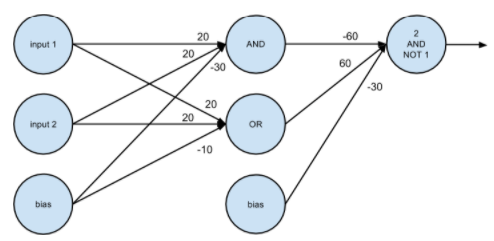

## Backpropagation

In [ ]:
def sqerror_gradients(network: List[List[Vector]],
                      input_vector: Vector,
                      target_vector: Vector) -> List[List[Vector]]:
    """
    Given a neural network, an input vector, and a target vector,
    make a prediction and compute the gradient of the squared error
    loss with respect to the neuron weights.
    """
    # forward pass
    hidden_outputs, outputs = feed_forward(network, input_vector)

    # gradients with respect to output neuron pre-activation outputs
    output_deltas = [output * (1 - output) * (output - target)
                     for output, target in zip(outputs, target_vector)]

    # gradients with respect to output neuron weights
    output_grads = [[output_deltas[i] * hidden_output
                     for hidden_output in hidden_outputs + [1]]
                    for i, output_neuron in enumerate(network[-1])]

    # gradients with respect to hidden neuron pre-activation outputs
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                         dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # gradients with respect to hidden neuron weights
    hidden_grads = [[hidden_deltas[i] * input for input in input_vector + [1]]
                    for i, hidden_neuron in enumerate(network[0])]

    return [hidden_grads, output_grads]

In [ ]:
import random
random.seed(0)

# training data
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

# start with random weights
network = [ # hidden layer: 2 inputs -> 2 outputs
            [[random.random() for _ in range(2 + 1)],   # 1st hidden neuron
             [random.random() for _ in range(2 + 1)]],  # 2nd hidden neuron
            # output layer: 2 inputs -> 1 output
            [[random.random() for _ in range(2 + 1)]]   # 1st output neuron
          ]

In [ ]:
from scratch.gradient_descent import gradient_step
import tqdm

learning_rate = 1.0

for epoch in tqdm.trange(20000, desc="neural net for xor"):
    for x, y in zip(xs, ys):
        gradients = sqerror_gradients(network, x, y)

        # Take a gradient step for each neuron in each layer
        network = [[gradient_step(neuron, grad, -learning_rate)
                    for neuron, grad in zip(layer, layer_grad)]
                   for layer, layer_grad in zip(network, gradients)]

# check that it learned XOR
assert feed_forward(network, [0, 0])[-1][0] < 0.01
assert feed_forward(network, [0, 1])[-1][0] > 0.99
assert feed_forward(network, [1, 0])[-1][0] > 0.99
assert feed_forward(network, [1, 1])[-1][0] < 0.01

## Example: Fizz Buzz

In [ ]:
def fizz_buzz_encode(x: int) -> Vector:
    if x % 15 == 0:
        return [0, 0, 0, 1]
    elif x % 5 == 0:
        return [0, 0, 1, 0]
    elif x % 3 == 0:
        return [0, 1, 0, 0]
    else:
        return [1, 0, 0, 0]

assert fizz_buzz_encode(2) == [1, 0, 0, 0]
assert fizz_buzz_encode(6) == [0, 1, 0, 0]
assert fizz_buzz_encode(10) == [0, 0, 1, 0]
assert fizz_buzz_encode(30) == [0, 0, 0, 1]

In [ ]:
def binary_encode(x: int) -> Vector:
    binary: List[float] = []

    for i in range(10):
        binary.append(x % 2)
        x = x // 2

    return binary

#                             1  2  4  8 16 32 64 128 256 512
assert binary_encode(0)   == [0, 0, 0, 0, 0, 0, 0, 0,  0,  0]
assert binary_encode(1)   == [1, 0, 0, 0, 0, 0, 0, 0,  0,  0]
assert binary_encode(10)  == [0, 1, 0, 1, 0, 0, 0, 0,  0,  0]
assert binary_encode(101) == [1, 0, 1, 0, 0, 1, 1, 0,  0,  0]
assert binary_encode(999) == [1, 1, 1, 0, 0, 1, 1, 1,  1,  1]

In [ ]:
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

In [ ]:
NUM_HIDDEN = 25

network = [
    # hidden layer: 10 inputs -> NUM_HIDDEN outputs
    [[random.random() for _ in range(10 + 1)] for _ in range(NUM_HIDDEN)],

    # output_layer: NUM_HIDDEN inputs -> 4 outputs
    [[random.random() for _ in range(NUM_HIDDEN + 1)] for _ in range(4)]
]

In [ ]:
from scratch.linear_algebra import squared_distance

learning_rate = 1.0

with tqdm.trange(500) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = feed_forward(network, x)[-1]
            epoch_loss += squared_distance(predicted, y)
            gradients = sqerror_gradients(network, x, y)

            # Take a gradient step for each neuron in each layer
            network = [[gradient_step(neuron, grad, -learning_rate)
                        for neuron, grad in zip(layer, layer_grad)]
                    for layer, layer_grad in zip(network, gradients)]

        t.set_description(f"fizz buzz (loss: {epoch_loss:.2f})")

In [ ]:
def argmax(xs: list) -> int:
    """Returns the index of the largest value"""
    return max(range(len(xs)), key=lambda i: xs[i])

assert argmax([0, -1]) == 0               # items[0] is largest
assert argmax([-1, 0]) == 1               # items[1] is largest
assert argmax([-1, 10, 5, 20, -3]) == 3   # items[3] is largest

In [ ]:
num_correct = 0

for n in range(1, 101):
    x = binary_encode(n)
    predicted = argmax(feed_forward(network, x)[-1])
    actual = argmax(fizz_buzz_encode(n))
    labels = [str(n), "fizz", "buzz", "fizzbuzz"]
    print(n, labels[predicted], labels[actual])

    if predicted == actual:
        num_correct += 1

print(num_correct, "/", 100)

- https://joelgrus.com/2016/05/23/fizz-buzz-in-tensorflow/